## Import TensorFlow and other libraries

In [1]:
import pyglet.window

In [2]:
import tensorflow as tf
%matplotlib notebook
%matplotlib inline
import os
import time
import numpy as np
import glob
import matplotlib.pyplot as plt
import PIL
import imageio
import cv2
import datetime
import random

from IPython import display

In [3]:
config = tf.compat.v1.ConfigProto()
config.gpu_options.allow_growth = True
session = tf.compat.v1.InteractiveSession(config=config)

In [4]:
epochs = 5000
batches_per_epoch_train = 500
batches_per_epoch_test = 30

batch_size = 16

## Load the MNIST dataset
Each MNIST image is originally a vector of 784 integers, each of which is between 0-255 and represents the intensity of a pixel. We model each pixel with a Bernoulli distribution in our model, and we statically binarize the dataset.

In [5]:
import gym

env_name = 'CarRacing-v0'
kwargs = {'verbose': False}

In [6]:
def VideoGenerator():
    while True:
        vidcap = cv2.VideoCapture('data/train.mp4')
        success, img = vidcap.read()

        while success:
            yield cv2.resize(img, (128, 128)).astype(np.float32) / 255
            success, img = vidcap.read()

In [7]:
class FramesGenerator:
    def __init__(self, **kwargs):
        self.env = gym.make(env_name, **kwargs)
        self.env.reset()
        self.iteration = 0

    def __next__(self):
        self.iteration += 1
        observation, reward, done, _ = self.env.step(self.env.action_space.sample()*[1,1,0])
        if done or self.iteration >= 1000:
            self.iteration = 0
            observation = self.env.reset()
        return cv2.resize(observation, (128, 128)).astype(np.float32) / 255
        
    def __iter__(self):
        return self
    def __del__(self):
        self.env.close()

In [8]:
gen = VideoGenerator()

In [9]:
next(gen).shape

(128, 128, 3)

<IPython.core.display.Javascript object>


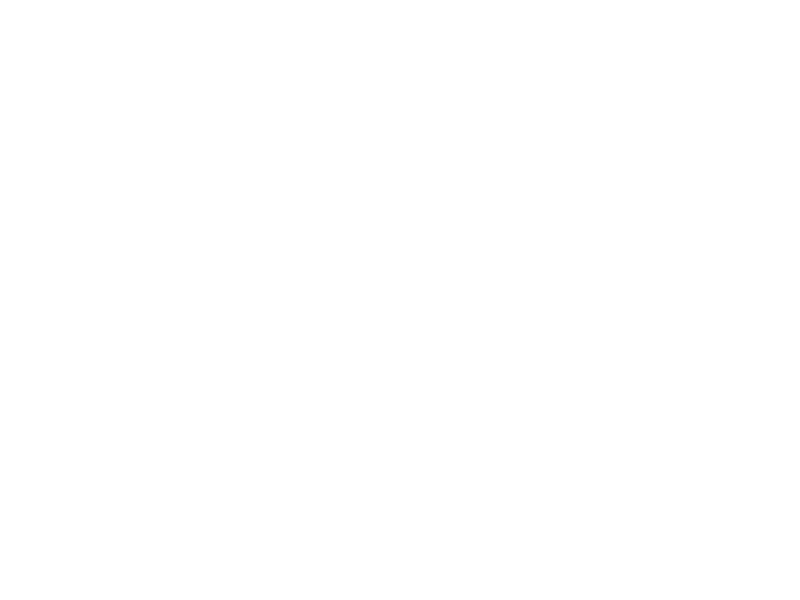

In [10]:
%matplotlib notebook
%matplotlib notebook

import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation

im = plt.imshow(next(gen))

def update(frame):
    plt.title(frame)
    im.set_array(next(gen))
    return [im]

anim = FuncAnimation(plt.gcf(), update, frames=10000, interval=10, blit=True)

In [11]:
%matplotlib inline
%matplotlib inline

Traceback (most recent call last):
  File "/home/leonid/anaconda3/lib/python3.7/site-packages/matplotlib/cbook/__init__.py", line 216, in process
    func(*args, **kwargs)
  File "/home/leonid/anaconda3/lib/python3.7/site-packages/matplotlib/animation.py", line 1465, in _stop
    self.event_source.remove_callback(self._loop_delay)
AttributeError: 'NoneType' object has no attribute 'remove_callback'


## Use *tf.data* to create batches and shuffle the dataset

In [12]:
def batches_generator(batch_size, buffer_size=3000):
    buffer = []
    while True:
        while len(buffer) < buffer_size:
            buffer.append(next(gen))
        random.shuffle(buffer)
        batch, buffer = buffer[:batch_size], buffer[batch_size:]
        yield np.array(batch)

## Wire up the generative and inference network with *tf.keras.Sequential*

In our VAE example, we use two small ConvNets for the generative and inference network. Since these neural nets are small, we use `tf.keras.Sequential` to simplify our code. Let $x$ and $z$ denote the observation and latent variable respectively in the following descriptions.

### Generative Network
This defines the generative model which takes a latent encoding as input, and outputs the parameters for a conditional distribution of the observation, i.e. $p(x|z)$. Additionally, we use a unit Gaussian prior $p(z)$ for the latent variable.

### Inference Network
This defines an approximate posterior distribution $q(z|x)$, which takes as input an observation and outputs a set of parameters for the conditional distribution of the latent representation. In this example, we simply model this distribution as a diagonal Gaussian. In this case, the inference network outputs the mean and log-variance parameters of a factorized Gaussian (log-variance instead of the variance directly is for numerical stability).

### Reparameterization Trick
During optimization, we can sample from $q(z|x)$ by first sampling from a unit Gaussian, and then multiplying by the standard deviation and adding the mean. This ensures the gradients could pass through the sample to the inference network parameters.

### Network architecture
For the inference network, we use two convolutional layers followed by a fully-connected layer. In the generative network, we mirror this architecture by using a fully-connected layer followed by three convolution transpose layers (a.k.a. deconvolutional layers in some contexts). Note, it's common practice to avoid using batch normalization when training VAEs, since the additional stochasticity due to using mini-batches may aggravate instability on top of the stochasticity from sampling.

In [13]:
class CVAE(tf.keras.Model):
    def __init__(self, latent_dim):
        super(CVAE, self).__init__()
        self.latent_dim = latent_dim
        self.inference_net = tf.keras.Sequential(
            [
                    tf.keras.layers.InputLayer(input_shape=(128, 128, 3)),
                    tf.keras.layers.Conv2D(
                            filters=128, kernel_size=4, strides=(2, 2), activation='relu'),
                    tf.keras.layers.Conv2D(
                            filters=128, kernel_size=4, strides=(2, 2), activation='relu'),
                    tf.keras.layers.Conv2D(
                            filters=256, kernel_size=4, strides=(2, 2), activation='relu'),
                    tf.keras.layers.Conv2D(
                            filters=256, kernel_size=4, strides=(2, 2), activation='relu'),
                    tf.keras.layers.Flatten(),
                    # No activation
                    tf.keras.layers.Dense(latent_dim + latent_dim),
            ]
        )

        self.generative_net = tf.keras.Sequential(
                [
                    tf.keras.layers.InputLayer(input_shape=(latent_dim,)),
                    tf.keras.layers.Dense(units=8*8*256, activation=tf.nn.relu),
                    tf.keras.layers.Reshape(target_shape=(8, 8, 256)),
                    tf.keras.layers.Conv2DTranspose(
                            filters=256,
                            kernel_size=4,
                            strides=(2, 2),
                            padding="SAME",
                            activation='relu'),
                    tf.keras.layers.Conv2DTranspose(
                            filters=256,
                            kernel_size=4,
                            strides=(2, 2),
                            padding="SAME",
                            activation='relu'),
                    tf.keras.layers.Conv2DTranspose(
                            filters=128,
                            kernel_size=4,
                            strides=(2, 2),
                            padding="SAME",
                            activation='relu'),
                    tf.keras.layers.Conv2DTranspose(
                            filters=128,
                            kernel_size=4,
                            strides=(2, 2),
                            padding="SAME",
                            activation='relu'),
                    # No activation
                    tf.keras.layers.Conv2DTranspose(
                            filters=3, kernel_size=4, strides=(1, 1), padding="SAME"),
                ]
        )

    @tf.function
    def sample(self, eps=None):
        if eps is None:
            eps = tf.random.normal(shape=(100, self.latent_dim))
        return self.decode(eps, apply_sigmoid=True)

    def encode(self, x):
        mean, logvar = tf.split(self.inference_net(x), num_or_size_splits=2, axis=1)
        return mean, logvar

    def reparameterize(self, mean, logvar):
        eps = tf.random.normal(shape=mean.shape)
        return eps * tf.exp(logvar * .5) + mean

    def decode(self, z, apply_sigmoid=False):
        logits = self.generative_net(z)
        if apply_sigmoid:
            probs = tf.sigmoid(logits)
            return probs

        return logits
    
    def call(self, inputs):
        return self.decode(self.encode(inputs)[0], apply_sigmoid=True)

## Define the loss function and the optimizer

VAEs train by maximizing the evidence lower bound (ELBO) on the marginal log-likelihood:

$$\log p(x) \ge \text{ELBO} = \mathbb{E}_{q(z|x)}\left[\log \frac{p(x, z)}{q(z|x)}\right].$$

In practice, we optimize the single sample Monte Carlo estimate of this expectation:

$$\log p(x| z) + \log p(z) - \log q(z|x),$$
where $z$ is sampled from $q(z|x)$.

**Note**: we could also analytically compute the KL term, but here we incorporate all three terms in the Monte Carlo estimator for simplicity.

In [14]:
optimizer = tf.keras.optimizers.Adam(1e-4)

def log_normal_pdf(sample, mean, logvar, raxis=1):
    log2pi = tf.math.log(2. * np.pi)
    return tf.reduce_sum(
            -.5 * ((sample - mean) ** 2. * tf.exp(-logvar) + logvar + log2pi),
            axis=raxis)

@tf.function
def compute_loss(model, x):
    mean, logvar = model.encode(x)
    z = model.reparameterize(mean, logvar)
    x_logit = model.decode(z)

    cross_ent = tf.nn.sigmoid_cross_entropy_with_logits(logits=x_logit, labels=x)
    logpx_z = -tf.reduce_sum(cross_ent, axis=[1, 2, 3])
    logpz = log_normal_pdf(z, 0., 0.)
    logqz_x = log_normal_pdf(z, mean, logvar)
    return -tf.reduce_mean(logpx_z + logpz - logqz_x)

@tf.function
def compute_apply_gradients(model, x, optimizer):
    with tf.GradientTape() as tape:
        loss = compute_loss(model, x)
    gradients = tape.gradient(loss, model.trainable_variables)
    optimizer.apply_gradients(zip(gradients, model.trainable_variables))

## Training

* We start by iterating over the dataset
* During each iteration, we pass the image to the encoder to obtain a set of mean and log-variance parameters of the approximate posterior $q(z|x)$
* We then apply the *reparameterization trick* to sample from $q(z|x)$
* Finally, we pass the reparameterized samples to the decoder to obtain the logits of the generative distribution $p(x|z)$
* **Note:** Since we use the dataset loaded by keras with 60k datapoints in the training set and 10k datapoints in the test set, our resulting ELBO on the test set is slightly higher than reported results in the literature which uses dynamic binarization of Larochelle's MNIST.

## Generate Images

* After training, it is time to generate some images
* We start by sampling a set of latent vectors from the unit Gaussian prior distribution $p(z)$
* The generator will then convert the latent sample $z$ to logits of the observation, giving a distribution $p(x|z)$
* Here we plot the probabilities of Bernoulli distributions


In [15]:
current_time = datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
test_log_dir = 'logs/gradient_tape/' + current_time + '/test'
test_summary_writer = tf.summary.create_file_writer(test_log_dir)

In [16]:
latent_dim = 256
num_examples_to_generate = 16

# keeping the random vector constant for generation (prediction) so
# it will be easier to see the improvement.
random_vector_for_generation = tf.random.normal(
        shape=[num_examples_to_generate, latent_dim])
model = CVAE(latent_dim)

In [17]:

model(next(batches_generator(batch_size)))
model.summary()

Model: "cvae"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
sequential (Sequential)      (None, 512)               6561024   
_________________________________________________________________
sequential_1 (Sequential)    (None, 128, 128, 3)       7101187   
Total params: 13,662,211
Trainable params: 13,662,211
Non-trainable params: 0
_________________________________________________________________


In [18]:
model.inference_net.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 63, 63, 128)       6272      
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 30, 30, 128)       262272    
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 14, 14, 256)       524544    
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 6, 6, 256)         1048832   
_________________________________________________________________
flatten (Flatten)            (None, 9216)              0         
_________________________________________________________________
dense (Dense)                (None, 512)               4719104   
Total params: 6,561,024
Trainable params: 6,561,024
Non-trainable params: 0
______________________________________________

In [19]:
model.generative_net.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 16384)             4210688   
_________________________________________________________________
reshape (Reshape)            (None, 8, 8, 256)         0         
_________________________________________________________________
conv2d_transpose (Conv2DTran (None, 16, 16, 256)       1048832   
_________________________________________________________________
conv2d_transpose_1 (Conv2DTr (None, 32, 32, 256)       1048832   
_________________________________________________________________
conv2d_transpose_2 (Conv2DTr (None, 64, 64, 128)       524416    
_________________________________________________________________
conv2d_transpose_3 (Conv2DTr (None, 128, 128, 128)     262272    
_________________________________________________________________
conv2d_transpose_4 (Conv2DTr (None, 128, 128, 3)      

In [20]:
def generate_and_save_images(model, epoch, test_input):
    predictions = model.sample(test_input)
    fig = plt.figure(figsize=(10,10))

    for i in range(predictions.shape[0]):
            plt.subplot(4, 4, i+1)
            plt.imshow(predictions[i, :, :])
            plt.axis('off')

    # tight_layout minimizes the overlap between 2 sub-plots
#     plt.savefig('image_at_epoch_{:04d}.png'.format(epoch))
    plt.show()

Epoch: 330, Test set ELBO: -10431.783203125, time elapse for current epoch 99.32243776321411


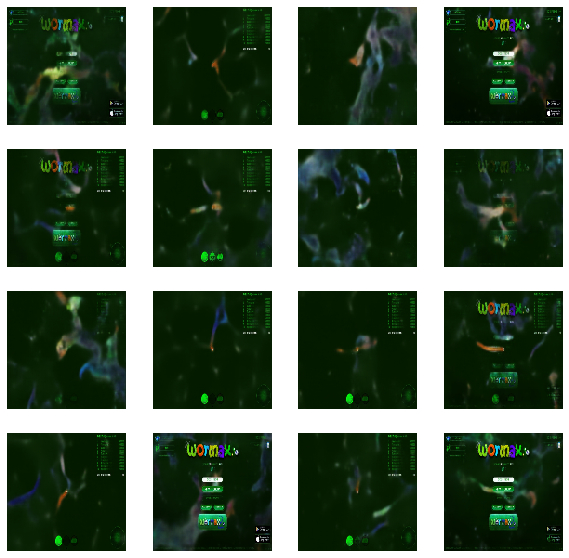

KeyboardInterrupt: 

In [21]:
%matplotlib inline
from tqdm.notebook import tqdm
generate_and_save_images(model, 0, random_vector_for_generation)

train_generator = batches_generator(batch_size)
test_generator = batches_generator(batch_size)

for epoch in range(1, epochs + 1):
    start_time = time.time()
    for i in tqdm(range(batches_per_epoch_train)):
        train_x = next(train_generator)
        compute_apply_gradients(model, train_x, optimizer)
    end_time = time.time()

    if epoch % 10 == 0:
        loss = tf.keras.metrics.Mean()
        for j in tqdm(range(batches_per_epoch_test)):
            test_x = next(test_generator)
            loss(compute_loss(model, test_x))
            
        elbo = -loss.result()
        
        with test_summary_writer.as_default():
            tf.summary.scalar('elbo', loss.result(), step=epoch)
            
        display.clear_output(wait=False)
        print('Epoch: {}, Test set ELBO: {}, '
                    'time elapse for current epoch {}'.format(epoch,
                                                                elbo,
                                                                end_time - start_time))
        generate_and_save_images(model, epoch, random_vector_for_generation)
        
        model_name = f'cvae_big_lat{latent_dim}_epoch{epoch}'
        model.save_weights(model_name)

In [24]:
model_name = f'cvae_big_lat{latent_dim}_epoch{110}'
model.load_weights(model_name)

### Display an image using the epoch number

In [ ]:
def display_image(epoch_no):
    return PIL.Image.open('image_at_epoch_{:04d}.png'.format(epoch_no))

In [ ]:
plt.imshow(display_image(22))
plt.axis('off')# Display images

### Generate a GIF of all the saved images.

In [ ]:
anim_file = 'cvae.gif'

with imageio.get_writer(anim_file, mode='I') as writer:
    filenames = glob.glob('image*.png')
    filenames = sorted(filenames)
    last = -1
    for i,filename in enumerate(filenames):
        frame = 2*(i**0.5)
        if round(frame) > round(last):
            last = frame
        else:
            continue
        image = imageio.imread(filename)
        writer.append_data(image)
    image = imageio.imread(filename)
    writer.append_data(image)

import IPython
if IPython.version_info >= (6,2,0,''):
    display.Image(filename=anim_file)

In [ ]:
from ipywidgets import interact, interactive, fixed, interact_manual


<IPython.core.display.Javascript object>


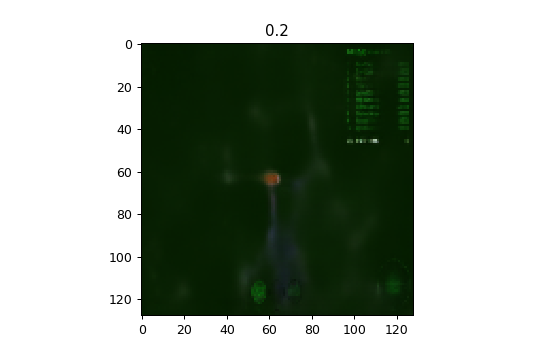

interactive(children=(FloatSlider(value=0.0, description='x0', max=1.0, min=-1.0), FloatSlider(value=0.0, desc…

In [27]:
%matplotlib notebook
import ipywidgets as widgets
from ipywidgets import interact
# sliders = [widgets.FloatSlider(min=-1, max=1) for i in range(10)]


def img_process(img):
    img = np.clip((img * 255).astype(np.int), 0, 255)
    return img

def sample(x):
    img = model.sample(x)[0]
    img = img.numpy()
    return img_process(img)

x = np.random.random(size=[1, latent_dim])
im = plt.imshow(sample(x))

@interact(x0=widgets.FloatSlider(min=-1, max=1),
            x1=widgets.FloatSlider(min=-1, max=1),
            x2=widgets.FloatSlider(min=-1, max=1),
            x3=widgets.FloatSlider(min=-1, max=1),
            x4=widgets.FloatSlider(min=-1, max=1),)
def value_changed(x0, x1, x2, x3, x4):
    plt.title(x1)
    n = 15
    x[0, 0], x[0, n + 1], x[0, n + 2], x[0, n + 3], x[0, n + 4] = x0, x1, x2, x3, x4
    print(x.shape)
    im.set_array(sample(x))
    
# for i in range(len(sliders)):
# slider.observe(value_changed, 'value')
# widgets.VBox(sliders)

In [ ]:
a = model.encode(next(gen)[np.newaxis,:])[0]
plt.imshow(next(gen))

In [ ]:
del plt
del FuncAnimation

<IPython.core.display.Javascript object>


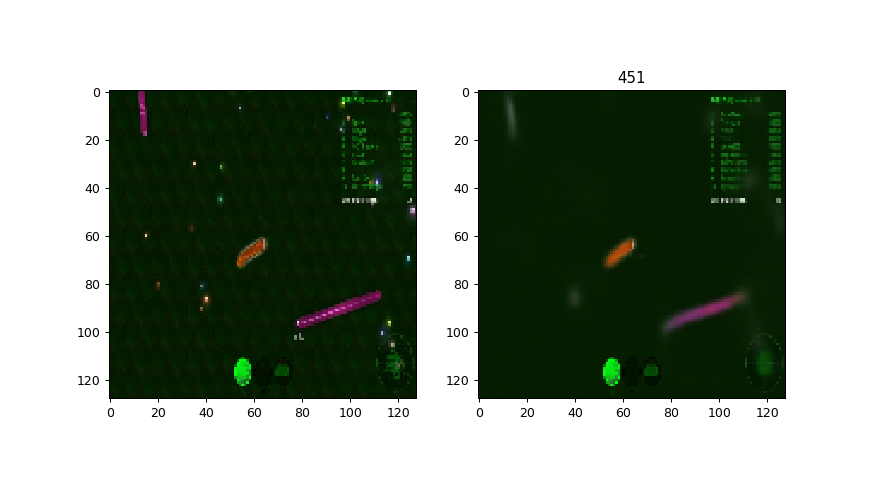

In [26]:
%matplotlib notebook
%matplotlib notebook

import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation

def img_process(img):
    img = np.clip((img * 255).astype(np.int), 0, 255)
    return img

def sample():
    x = np.random.random(size=[1, latent_dim])
    img = model.sample(x)[0]
    img = img.numpy()
    return img_process(img)


plt.subplot(1, 2, 1)
im1 = plt.imshow(next(gen))

plt.subplot(1, 2, 2)
im2 = plt.imshow(next(gen))

def update(frame):
    if frame % 100 == 0:
        for i in range(200):
            next(gen)
    img = next(gen)
    im1.set_array(img)
    
    plt.title(frame)

    img = model(img[np.newaxis,:])[0].numpy()
    img = img_process(img)
    im2.set_array(img)
    return [im1, im2]

anim = FuncAnimation(plt.gcf(), update, frames=10000, interval=100, blit=True)

In [ ]:
%matplotlib inline

In [ ]:
# for i in range(1000):
#     next(gen)
plt.imshow(next(gen))

In [ ]:
img = next(gen)
im1.set_array(img_process(img))

plt.title(str(img.shape))

img = model(img[np.newaxis,:])[0]
img = img_process(img)
im1.set_array(img)

In [ ]:
%matplotlib inline

batch = next(iter(test_dataset))
img = tf.nn.sigmoid(model(batch)[0])
img = img.numpy()
img = np.clip((img * 255).astype(np.int), 0, 255)
img_orig = np.clip((batch[0].numpy() * 255).astype(np.int), 0, 255)

plt.subplot(1, 2, 1)
plt.imshow(img_orig)
plt.subplot(1, 2, 2)
plt.imshow(img, )

In [ ]:
for i in [img, img_orig, sample(1)]:
    print(i.max())
    print(i.min())    
    print(i.dtype)    
    print(i[0][2])
    print(i.shape)
    print()    